<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Andrew/NuGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up the environment

In [1]:
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
from math import floor

# Download the MNIST dataset

[MNIST PyTorch Docs](https://pytorch.org/vision/stable/datasets.html#mnist)

In [2]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Showing shape of train and test dataset

In [3]:
print("Train Shape:", train_dataset.data.shape, "Test Shape:", test_dataset.data.shape)

Train Shape: torch.Size([60000, 28, 28]) Test Shape: torch.Size([10000, 28, 28])


In [4]:
class Net(nn.Module):
    def __init__(self, input_dim=1, output_dim=10, input_size=28, base_size=64):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size
        # self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.conv2 = nn.Conv2d(16, 128, kernel_size=3, stride=1, padding=1)
        # self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(128 * 8 * 8, 512)
        # self.fc2 = nn.Linear(512, 128)
        # self.fc3 = nn.Linear(128, 10)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.ReLU(),
        )

        #initialize_weights(self)

    def forward(self, x):
        # x = self.pool(F.relu(self.conv1(x)))
        # x = self.pool(F.relu(self.conv2(x)))
        # x = F.relu(self.conv3(x))
        # x = x.view(-1, 128 * 8 * 8)
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)
        return x

In [5]:
class Classifier():
    def __init__(self, epoch=20, batch_size=500):

        self.epoch_range = epoch
        self.batch_size = batch_size
        valid_ratio = 0.3

        nb_train = int((1.0 - valid_ratio) * len(train_dataset))
        nb_valid =  int(valid_ratio * len(train_dataset))
        train_split_dataset, valid_split_dataset = torch.utils.data.dataset.random_split(train_dataset, [nb_train, nb_valid])

        self.trainloader = torch.utils.data.DataLoader(train_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.validloader = torch.utils.data.DataLoader(valid_split_dataset, batch_size=self.batch_size,
                                          shuffle=True)
        self.testloader = torch.utils.data.DataLoader(test_dataset, 
                                        batch_size=self.batch_size, 
                                        shuffle=False,
                                        num_workers=1)

        self.net = Net().cuda()

        self.criterion = nn.CrossEntropyLoss().cuda()

        self.optimizer = optim.Adam(self.net.parameters(), lr=0.00146)

        from google.colab import drive
        drive.mount('/content/drive')
        self.PATH = 'cifar10_net_test_3.pth'


        # Function to train the CNN classifier
#--------------------------------------------------------------------------------------------------------

    def train(self):

        self.training_loss = []
        self.validation_loss = []

        start_time = time.time()
        best_loss = np.float('inf')
        for epoch in range(self.epoch_range): 

            running_loss = 0.0
            for i, data in enumerate(self.trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                # inputs, labels = data[0].to(device), data[1].to(device)
                inputs, labels = data[0].cuda(), data[1].cuda()

                # zero the parameter gradients
                self.optimizer.zero_grad()

                # forward + backward + optimize
                outputs = self.net(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                # print statistics
                running_loss += loss.item()

            epoch_loss = running_loss / (i+1)
            self.training_loss.append(epoch_loss)
            print("Epoch: ", epoch, " train loss: ", '%.3f' % epoch_loss)

            #---------------------------------

            with torch.no_grad(): 
                running_loss = 0.0

                for i, data in enumerate(self.validloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    #inputs, labels = data[0].to(device), data[1].to(device)
                    inputs, labels = data[0].cuda(), data[1].cuda()

                    # forward 
                    outputs = self.net(inputs)
                    loss = self.criterion(outputs, labels)

                    # print statistics
                    running_loss += loss.item()


                epoch_loss = running_loss / (i+1)
                self.validation_loss.append(epoch_loss)
                print("Epoch: ", epoch, " validation loss: ", '%.3f' % epoch_loss)

                # save the best model based on validation loss
                if epoch_loss < best_loss:
                    torch.save(self.net.state_dict(), self.PATH)
                    best_loss = epoch_loss

        time_elap = (time.time() - start_time) // 60
        print('Finished Training in %d mins' % time_elap)

        plt.plot(range(self.epoch_range), self.training_loss, 'k-')
        plt.title('train loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('train_loss')
        plt.show()

        plt.plot(range(self.epoch_range), self.validation_loss, 'k-')
        plt.title('validation loss vs. epoch')
        plt.xlabel('epoch')
        plt.ylabel('validation_loss')
        plt.show()


    def test_accuracy(self):

        correct = 0
        total = 0

        with torch.no_grad():
            for data in self.testloader:
                images, labels = data
                outputs = self.net(images.cuda())
                #print("Outputs shape:", outputs.shape)
                _, predicted = torch.max(outputs.data, 1)
                #print("predicted:", predicted.shape)
                total += labels.size(0)
                correct += (predicted == labels.cuda()).sum().item()

        print('Accuracy of the network on the 10000 test images: %.3F %%' % (
            100 * correct / total))


# Train MNIST Classifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch:  0  train loss:  0.212
Epoch:  0  validation loss:  0.081
Epoch:  1  train loss:  0.058
Epoch:  1  validation loss:  0.059
Epoch:  2  train loss:  0.036
Epoch:  2  validation loss:  0.055
Epoch:  3  train loss:  0.025
Epoch:  3  validation loss:  0.056
Epoch:  4  train loss:  0.018
Epoch:  4  validation loss:  0.054
Epoch:  5  train loss:  0.012
Epoch:  5  validation loss:  0.054
Epoch:  6  train loss:  0.011
Epoch:  6  validation loss:  0.056
Epoch:  7  train loss:  0.006
Epoch:  7  validation loss:  0.053
Epoch:  8  train loss:  0.005
Epoch:  8  validation loss:  0.053
Epoch:  9  train loss:  0.004
Epoch:  9  validation loss:  0.054
Epoch:  10  train loss:  0.005
Epoch:  10  validation loss:  0.058
Epoch:  11  train loss:  0.007
Epoch:  11  validation loss:  0.071
Epoch:  12  train loss:  0.014
Epoch:  12  validation loss:  0.066
Epoch:  13  train lo

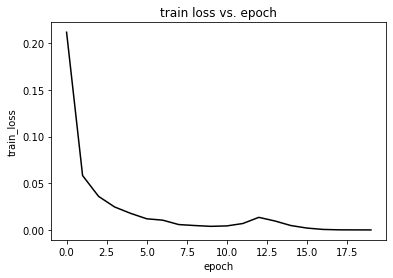

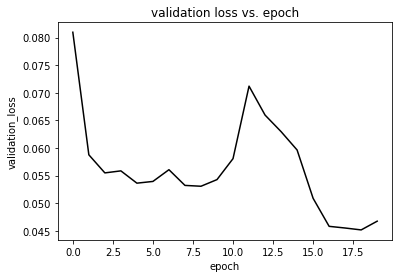

In [6]:
classifier = Classifier()
classifier.train()

In [7]:
classifier.test_accuracy()

Accuracy of the network on the 10000 test images: 98.880 %


# Define a function to initialize the weights of the network


In [8]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [9]:
def visualize_results(gan):
      mtx_size = 10
      sample_z_ = torch.rand((mtx_size * mtx_size, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((mtx_size, mtx_size)))
      fig,ax = plt.subplots(mtx_size, mtx_size)

      i = 0
      for x in range(mtx_size):
          for y in range(mtx_size):
              i = x*mtx_size + y
              s=ax[x][y].imshow(np.squeeze(samples[i,]))
              s=ax[x][y].get_xaxis().set_visible(False)
              s=ax[x][y].get_yaxis().set_visible(False)
      s=plt.show()

# Method for determinign inception score of GAN

[Article for help implementing](https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/)

In [55]:
def inception_score(gan, n_split=10, eps=1E-16):

      num_images = 100
      sample_z_ = torch.rand((num_images, gan.z_dim)).cuda()
      #print(sample_z_.shape)
      samples = gan.G(sample_z_)
      #print(samples.shape)

      samples_np = samples.cpu().data.numpy()

      # enumerate splits of images/predictions
      scores = list()
      n_part = floor(num_images / n_split)

      for i in range(n_part):
          # retrieve subset of images
          ix_start, ix_end = i * n_part, (i+1) * n_part
          subset = samples_np[ix_start:ix_end]
          # convert from uint8 to float32
          subset = subset.astype('float32')
          # predict p(y|x)
          outputs = classifier.net(torch.from_numpy(subset).cuda())
          print("outputs: ", outputs.shape)
          print("\t", outputs)
          
          y, p_yx = torch.max(outputs.data, 1)
          print("p_yx: ", p_yx.shape)
          print("\t", p_yx)
          #print(y.shape)
          p_yx_d = gan.D(torch.from_numpy(subset).cuda())
          print("\tD: ", p_yx_d.shape)
          #print(p_yx.shape)
          #print(p_yx)
          p_yx = p_yx.cpu().data.numpy()
          print("p_yx numpy", p_yx)
          p_yx = np.expand_dims(p_yx, 0)
          #print(p_yx.shape)
          print("p_yx expanded", p_yx)
          # calculate p(y)
          p_y = np.expand_dims(p_yx.mean(axis=1), 0)
          print("p_y", p_y)
          # calculate KL divergence using log probabilities
          kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
          print("kl_d", kl_d)
          # sum over classes
          sum_kl_d = kl_d.sum(axis=1)
          print("sum_kl_d", sum_kl_d)
          # average over images
          avg_kl_d = np.mean(sum_kl_d)
          print("avg_kl_d", avg_kl_d)
          # undo the log
          is_score = np.exp(avg_kl_d)
          print("is_score", is_score)
          print('\n\n')
		      # store
          scores.append(is_score)
        
      # average across images
      is_avg, is_std = np.mean(scores), np.std(scores)
     
      print(is_avg, is_std)

      # Get predictions
      # The inception score has a lowest value of 1.0 and a highest value of the number of classes supported by the classification model; 
      # In the MNIST dataset, there are 10 classes
      #preds = np.zeros((N, 10))

In [11]:
from scipy.sparse import linalg

def get_eigenvectors(model, loss, dataloader):
    # Adds up the number of weights in the model
    num_params = sum(p.numel() for p in model.parameters())

    hv = HessianVector(model=model, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Calculates the Eigenvalues of the Discriminator


[linalg.eigsh](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html)

In [12]:
def get_d_eigenvectors(D, G, loss, dataloader):

    num_params = sum(p.numel() for p in D.parameters())

    hv = HessianVector(model=D, 
                       dataloader=dataloader, 
                       loss=loss)
    
    A = linalg.LinearOperator((num_params,num_params), matvec=lambda v: hv.calculate(torch.tensor(v).float()))

    print("\tGot eigenvectors", A.shape)
    # Gets 'k' with the Largest (algebraic) eigenvalues
    vals, vecs = linalg.eigsh(A, k=2, mode='LA')

    print("\tEigenvalues are {:.2f} and {:.2f}".format(vals[0],vals[1]))

# Hessian Vector Class



*   scipy.sparse.linalg.LinearOperator
  *   [Docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.LinearOperator.html)



In [13]:
class HessianVector():

    def __init__(self, model, dataloader, loss, percentage=0.2):
        self.size = int(sum(param.numel() for param in model.parameters()))
        self.grad_vec = torch.zeros(self.size)
        self.percentage = percentage
        self.dataloader = dataloader
        self.model = model
        self.loss = loss


    def calculate(self, vector):
        full_hessian = None
        # Place vector on the GPU
        vector = vector.cuda()

        grad_vec = None

        batch_grad = self.prepare_grad()

        #print("Batch Shape:", batch_grad.shape)

        self.zero_grad()
        # Take the second gradient
        grad_grad = torch.autograd.grad(batch_grad, self.model.parameters(), grad_outputs=vector, only_inputs=True, retain_graph=True)
        # Concatentate the results over the different components of the network
        hessian_vec_prod = torch.cat([g.contiguous().view(-1) for g in grad_grad])
        # Adds/Sets Full Hessian
        if full_hessian is not None:
            full_hessian += hessian_vec_prod
        else:
            full_hessian = hessian_vec_prod

        # Hessian must be returned on the CPU
        return full_hessian.cpu()

    def zero_grad(self):
        """
        Zeros out the gradient info for each parameters and vectorize
        """

        for p in self.model.parameters():
            if p.grad is not None:
                p.grad.data.zero_()


    def prepare_grad(self):


        grad_vec = None

        grad_dict = torch.autograd.grad(self.loss, self.model.parameters(), create_graph=True, retain_graph=True)
        grad_vec = torch.cat([g.contiguous().view(-1) for g in grad_dict])
        self.grad_vec = grad_vec
        return self.grad_vec


# Generator and Discriminator class definition

In [18]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32, base_size=64):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size    


        # self.fc1 = nn.Linear(self.input_dim, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim * self.input_size * self.input_size)

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            #nn.ReLU(),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            #nn.ReLU(),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x): 

        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = torch.tanh(self.fc4(x))
        # x = x.view(-1, self.output_dim, self.input_size, self.input_size)
        # return x

        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x
    
class Discriminator(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, input_size=32, base_size=64):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size

        # self.fc1 = nn.Linear(self.input_size * self.input_size, self.base_size)
        # self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        # self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        # self.fc4 = nn.Linear(self.fc3.out_features, self.output_dim)

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)
    
    # forward method
    def forward(self, x):

        # x = x.view(-1, self.input_size * self.input_size)
        # x = F.leaky_relu(self.fc1(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc2(x), 0.2)
        # x = F.dropout(x, 0.3)
        # x = F.leaky_relu(self.fc3(x), 0.2)
        # x = F.dropout(x, 0.3)
        # return torch.sigmoid(self.fc4(x))

        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

# Construction of GAN model

[Modifying gradients in PyTorch](https://discuss.pytorch.org/t/how-to-modify-the-gradient-manually/7483)

In [56]:
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 300
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]

        #mnist_dim = data.shape[1] * data.shape[2]

        #print(data.shape)
        #self.data_width = data.shape[2]
        #self.data_height = data.shape[3]

        # initialization of the generator and discriminator
        self.G = Generator(
            input_dim=self.z_dim,       # 16
            output_dim=data.shape[1],   # 1
            input_size=self.input_size, # 28
            base_size=self.base_size    # 64
            ).cuda()

        self.D = Discriminator(
            input_dim=data.shape[1],    
            output_dim=1,
            input_size=self.input_size, 
            base_size=self.base_size
            ).cuda()

        #print("Encoder", data.shape[1], self.input_size, self.base_size)
        #self.E = encoder(input_dim=data.shape[1], output_dim=self.z_dim, input_size=self.input_size, base_size=self.base_size).cuda()
        #self.G_optimizer = optim.SGD(self.G.parameters(), lr=params['lr_g'])
        #self.D_optimizer = optim.SGD(self.D.parameters(), lr=params['lr_d'])
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_d'], betas=(params['beta1'], params['beta2']))
        #self.E_optimizer = optim.Adam(self.E.parameters(), lr=1e-2, weight_decay=1e-4)
        
        # initialization of the loss function

        self.BCE_loss = nn.BCELoss().cuda()
        #self.smooth_loss = nn.SmoothL1Loss().cuda()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()

        # Function to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        Ninner = 1
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        #self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).cuda(), torch.zeros(self.batch_size, 1).cuda()
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).fill_(0.1).type(torch.float32).cuda()
        # print(self.y_real_.shape)
        self.y_real_ = self.y_real_ + (torch.randn(self.y_real_.shape)*0.03).cuda()
        self.y_fake_ = self.y_fake_ + (torch.randn(self.y_fake_.shape)*0.03).cuda()

        print('training start!!')

        randn_var = 0.05
        randn_mean = 0.00

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()
            print("Epoch:", epoch+1)

            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()

                # YOUR CODE HERE
                #--------------------

                # update D network using 
                # 1. Set optimizer gradient to zero
                self.D_optimizer.zero_grad()
                # 2. Set discriminator losses on real and fake data
                x_ = x_ + torch.normal(mean=randn_mean, std=randn_var, size=x_.shape).cuda()
                #x_ = x_ + (torch.randn(x_.shape)*randn_var + randn_mean).cuda() # Adding random noise to input images
                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                z_ = z_ + torch.normal(mean=randn_mean, std=randn_var, size=z_.shape).cuda()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)
                # 3. Do back propagation to compute gradients
                D_loss = D_real_loss + D_fake_loss

                if (iter == 0) and (((epoch + 1) % 10) == 0):
                    get_eigenvectors(self.D, D_loss, self.data_loader)

                D_loss.backward()

                # if iter == 0:
                #     print("D eigen vectors:")
                #     get_eigenvectors(self.D, self.data_loader, self.BCE_loss)


                # 4. Make a step of D_optimizer
                self.D_optimizer.step()
                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                self.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = self.G(z_)
                D_fake_ = self.D(G_)
                G_loss = self.BCE_loss(D_fake_, self.y_real_)
                if (iter == 0) and (((epoch + 1) % 10) == 0):
                    get_eigenvectors(self.G, G_loss, self.data_loader)
                # 3. Do back propagation to compute gradients
                G_loss.backward()

                # if iter == 0:
                #     print("G eigen vectors:")
                #     get_eigenvectors(self.G, self.data_loader, self.BCE_loss)

                # 4. Make a step of G_optimizer
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses
                
                if ((iter + 1) % 50) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))
                
            # Visualize results
            if ((epoch + 1) % 1) == 0:
                with torch.no_grad():
                    visualize_results(self)
                    inception_score(self)
                #visualize_gan_optim_loss(self)

        print("Training finished!")

# Training the GAN

training start!!
Epoch: 1
Epoch: [ 1] [  50/ 200] D_loss: 1.23090804, G_loss: 0.96495301
Epoch: [ 1] [ 100/ 200] D_loss: 1.02954102, G_loss: 1.05920672
Epoch: [ 1] [ 150/ 200] D_loss: 1.02652848, G_loss: 1.11083055
Epoch: [ 1] [ 200/ 200] D_loss: 1.01588130, G_loss: 1.62988365


<Figure size 720x720 with 0 Axes>

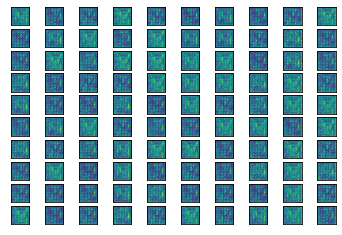

outputs:  torch.Size([10, 10])
	 tensor([[ 2.0396,  0.0000,  8.3578,  2.0701,  0.0000,  1.4857,  0.0000,  0.0000,
          0.0000,  2.3205],
        [ 0.0000,  8.9474,  4.4323,  0.0000,  0.0000,  0.0000,  0.0000,  2.0892,
          2.5545,  0.0000],
        [ 0.0000,  8.9673,  4.0686,  0.0000,  0.0000,  0.0000,  0.0000,  1.2098,
          4.8247,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  2.0808,  3.2970,  5.7275,  0.0000,  0.0000,
          0.0000, 17.3889],
        [ 1.1490,  9.1913,  3.3434,  0.0000,  0.0000,  0.0000,  0.0000,  3.9772,
          0.0000,  0.0000],
        [ 8.3494,  0.1933,  5.0180,  1.2704,  0.0000,  0.0000,  0.0000,  2.0483,
          0.0000,  0.0000],
        [ 0.6025,  9.1046,  3.6340,  0.0000,  0.0000,  0.0000,  0.0000,  3.7441,
          0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  3.9103,  1.9254,  7.5047,  0.0000,  0.0000,
          0.9688, 15.1541],
        [ 0.0000,  0.0000,  0.0000,  7.0833,  0.0000,  4.7758,  0.0000,  0.0000,
         10.21

In [57]:
params = {'beta1': 0.5, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':1}
params['z_dim'] = 1
params['base_size'] = 64

gan = GAN(params)
gan.train()

# Loss History for GAN optimization

* The <font color='lightblue'>discriminator</font> loss will achieve a low value when it can reliably 
separate the two classes.

* The <font color='red'>generator</font> loss will achieve a low value when it can successfully fool the discriminator

In [ ]:
plt.figure(figsize=(16,8))
s=plt.plot(gan.train_hist['D_loss'],c='b')
s=plt.plot(gan.train_hist['G_loss'],c='r')
s = plt.ylim((0,3))
s = plt.grid()
s=plt.legend(('Discriminator loss','Generator loss'))